In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from numpy.linalg import inv, norm
from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import neighbors, datasets
import os
import math
import pickle
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from scipy.special import softmax, expit

from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, log_loss
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

# few global variables
ind = [1,2,3,9]
cmap_bold = [sns.color_palette('bright')[i] for i in ind]
cmap_light = [sns.color_palette('dark')[i] for i in ind]

# Dataset 2A

In [1]:
classes = ['highway', 'insidecity', 'mountain', 'opencountry', 'tallbuilding']
class_to_ind = {}
for i,c in enumerate(classes):
    class_to_ind[c] = i
class_to_ind

for (i,c) in enumerate(classes):
    print(i,c,sep=' ')


0 highway
1 insidecity
2 mountain
3 opencountry
4 tallbuilding


In [4]:
# Loading Dataset 2A
y_train = []
x_train = None

x_class_tr = {} ; y_class_tr = {}  # dict for storing the training points of each class separately
x_class_va = {} ; y_class_va = {} # dict for storing the validations points of each class separately
x_class_te = {} ; y_class_te = {}  # dict for storing the test points of each class separately
len_tr, len_te , len_va = {},{},{}

print('Training Set : ')
for (i,c) in enumerate(classes):
    print(c)
    fil = 'E:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_2A/'+c+'/train.csv'
    df = pd.read_csv(fil)
    x_class_tr[i] = np.array(df.iloc[:,range(1,25,1)])
    len_tr[i] = df.shape[0] 
    if(x_train is None):
        x_train = np.array(df.iloc[:,range(1,25,1)])
    else:
        x_train = np.r_[x_train, np.array(df.iloc[:,range(1,25,1)])]
    y_train = y_train + [class_to_ind[c]]*df.shape[0]
    print(' ',c, df.shape[0])
y_train = np.array(y_train)

y_test = []
y_va = []
x_va = None
x_test = None
print('Dev Set : ')
for (i,c) in enumerate(classes):
    fil = 'E:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_2A/'+c+'/dev.csv'
    df = pd.read_csv(fil)
    nc = df.shape[0]
    x_class_va[i] = np.array(df.iloc[:int(0.6*nc),range(1,25,1)])
    x_class_te[i] = np.array(df.iloc[int(0.6*nc):,range(1,25,1)])
    len_va[i] = int(0.6*nc)
    len_te[i] = nc-int(0.6*nc)
    if(x_test is None):
        x_test = np.array(df.iloc[int(0.6*nc):,range(1,25,1)])
        x_va = np.array(df.iloc[:int(0.6*nc),range(1,25,1)])
    else:
        x_test = np.r_[x_test, np.array(df.iloc[int(0.6*nc):,range(1,25,1)])]
        x_va = np.r_[x_va, np.array(df.iloc[:int(0.6*nc),range(1,25,1)])]
    y_va = y_va + [class_to_ind[c]]*int(0.6*nc)
    y_test = y_test + [class_to_ind[c]]*(nc - int(0.6*nc))
    print(' ',c, df.shape[0])
y_test = np.array(y_test)
y_va = np.array(y_va)
y_va.shape

Training Set : 
highway
  highway 182
insidecity
  insidecity 215
mountain
  mountain 261
opencountry
  opencountry 287
tallbuilding
  tallbuilding 249
Dev Set : 
  highway 52
  insidecity 62
  mountain 75
  opencountry 82
  tallbuilding 71


(204,)

In [15]:
#utilities
def build_mlfnn(hidden_neurons,num_layers=1,num_classes=4): #hidden neurons is a list of number of hidden units in each hidden layer
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(24)))
    model.add(tf.keras.layers.Dense(hidden_neurons[0],activation='relu'))
    if num_layers==2:
        model.add(tf .keras.layers.Dense(hidden_neurons[1],activation='relu'))

    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    return model

def train_model(model,epochs,X_train,Y_train,X_valid,Y_valid,verbose = 0):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=1),metrics=['accuracy'])
    history=model.fit(X_train,Y_train,epochs=epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=verbose)
    return history

In [25]:
# tables of classification accuracy for different values of hyperparameters
seed(0) 
set_seed(0)

epochs = 200
model_metrics = {}

list_h_neurons = [[20,20,20],[12,12],[13,13],[14,14],[15,15],[16,16],[17,17],[18,18],[20,20],[22,22],[24,24],[26,26],[24],[25],[26],[27],[28],[29],[30],[31],[32],[35],[36],[40],[44],[48],[52]]
for (count,h_neurons) in enumerate(list_h_neurons):
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=5)
    train_model(model,epochs,x_train,y_train,x_va,y_va)
    print('\n *************************************************** \n')
    y_tr_predict = model.predict(x_train) ; y_tr_predict = np.argmax(y_tr_predict,axis=1)
    y_va_predict = model.predict(x_va)    ; y_va_predict = np.argmax(y_va_predict,axis=1)
    # y_te_predict = model.predict(x_te)    ; y_te_predict = np.argmax(y_te_predict,axis=1) 
    
    tr_loss, tr_acc = model.evaluate(x_train,y_train,verbose=1)
    va_loss, va_acc = model.evaluate(x_va,y_va,verbose=1)
    model_metrics[count] = (h_neurons,round(tr_loss,3),round(tr_acc,3)*100,round(va_loss,3),round(va_acc,3)*100)
print('h_neurons' , 'training loss', 'training accuracy', 'validation loss' , 'validation accuracy')
for i in range(len(model_metrics)):
    print(model_metrics[i])


 *************************************************** 

7/7 [==============================] - 0s 712us/step - loss: 1.6084 - accuracy: 0.5343

 *************************************************** 

7/7 [==============================] - 0s 765us/step - loss: 1.4821 - accuracy: 0.4657

 *************************************************** 

7/7 [==============================] - 0s 780us/step - loss: 1.5144 - accuracy: 0.4853

 *************************************************** 

7/7 [==============================] - 0s 712us/step - loss: 1.6197 - accuracy: 0.4755

 *************************************************** 

7/7 [==============================] - 0s 680us/step - loss: 1.7517 - accuracy: 0.5196

 *************************************************** 

7/7 [==============================] - 0s 774us/step - loss: 1.4978 - accuracy: 0.5049

 *************************************************** 

7/7 [==============================] - 0s 997us/step - loss: 1.6250 - accuracy: 0.5098

In [26]:
# tables of classification accuracy for different values of hyperparameters
seed(0) 
set_seed(0)

epochs = 200
model_metrics = {}

list_h_neurons = [[20,20,20],[22,22,22],[24,24,24],[28,28,28],[60],[70],[80],[90]]
for (count,h_neurons) in enumerate(list_h_neurons):
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=5)
    train_model(model,epochs,x_train,y_train,x_va,y_va)
    print('\n *************************************************** \n')
    y_tr_predict = model.predict(x_train) ; y_tr_predict = np.argmax(y_tr_predict,axis=1)
    y_va_predict = model.predict(x_va)    ; y_va_predict = np.argmax(y_va_predict,axis=1)
    # y_te_predict = model.predict(x_te)    ; y_te_predict = np.argmax(y_te_predict,axis=1) 
    
    tr_loss, tr_acc = model.evaluate(x_train,y_train,verbose=1)
    va_loss, va_acc = model.evaluate(x_va,y_va,verbose=1)
    model_metrics[count] = (h_neurons,round(tr_loss,3),round(tr_acc,3)*100,round(va_loss,3),round(va_acc,3)*100)
print('h_neurons' , 'training loss', 'training accuracy', 'validation loss' , 'validation accuracy')
for i in range(len(model_metrics)):
    print(model_metrics[i])


 *************************************************** 

7/7 [==============================] - 0s 909us/step - loss: 1.6084 - accuracy: 0.5343

 *************************************************** 

7/7 [==============================] - 0s 1ms/step - loss: 1.9243 - accuracy: 0.5000

 *************************************************** 

7/7 [==============================] - 0s 717us/step - loss: 1.6914 - accuracy: 0.5245

 *************************************************** 

7/7 [==============================] - 0s 1ms/step - loss: 1.6238 - accuracy: 0.5049

 *************************************************** 

7/7 [==============================] - 0s 1ms/step - loss: 2.2862 - accuracy: 0.4951

 *************************************************** 

7/7 [==============================] - 0s 1ms/step - loss: 2.8286 - accuracy: 0.4804

 *************************************************** 

7/7 [==============================] - 0s 998us/step - loss: 2.4590 - accuracy: 0.5343

 *****

The best model according to the above two cells is the one with single hidden layer and 48 neurons

In [27]:
# classification accuracy of best model on test data
seed(0)
set_seed(0)
epochs = 200
best_h_neurons = [48]
model = build_mlfnn(hidden_neurons=best_h_neurons,num_layers=len(best_h_neurons),num_classes=5)
train_model(model,epochs,x_train,y_train,x_va,y_va)

te_loss,te_acc = model.evaluate(x_test,y_test)
print(round(te_loss,3),te_acc*100)

5/5 [==============================] - 0s 798us/step - loss: 1.8413 - accuracy: 0.5217
1.841 52.173912525177


7/7 [==============================] - 0s 1ms/step - loss: 2.3208 - accuracy: 0.5098


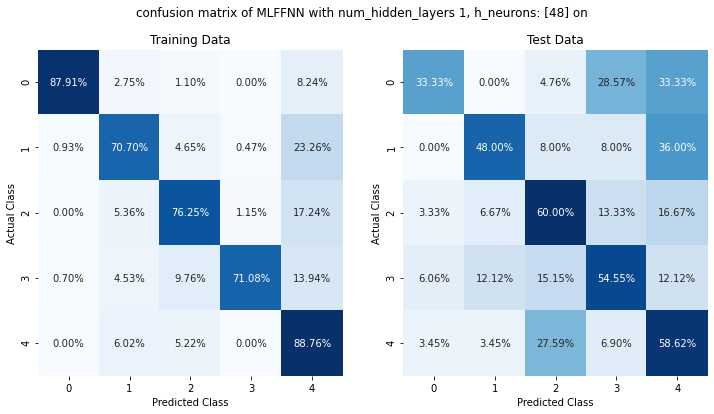

In [29]:
#confusion matrix for best model on Training and Test Data
seed(0)
set_seed(0)
best_h_neurons = [48]
epochs = 200
model = build_mlfnn(hidden_neurons=best_h_neurons,num_layers=len(best_h_neurons),num_classes=5)
train_model(model,epochs,x_train,y_train,x_va,y_va)

yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
yhat_te = model.predict(x_test)  ; yhat_te = np.argmax(yhat_te,axis=1)
model.evaluate(x_train,y_train) ; model.evaluate(x_va,y_va)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of MLFFNN with num_hidden_layers {len(best_h_neurons)}, h_neurons: {best_h_neurons} on')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true')if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()

## Gaussian SVM

In [36]:
# checking the hyperparameter - gamma
classes = ['highway', 'insidecity', 'mountain', 'opencountry', 'tallbuilding']
gammas = [1e-4,1e-3,1e-2,1e-1,1,1e1] ; c = 100
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for gamma in gammas:
    #creating a ovr classifier
    print(gamma,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((gamma,round(tr_acc,3),round(va_acc,3)))

print('gamma, training accuracy, validation accuracy:')
for i in range(len(gammas)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 gamma, training accuracy, validation accuracy:
(0.0001, 0.507, 0.392)
(0.001, 0.506, 0.397)
(0.01, 0.563, 0.475)
(0.1, 0.668, 0.529)
(1, 0.885, 0.539)
(10.0, 1.0, 0.515)


In [37]:
# checking the hyperparameter - c
classes = ['highway', 'insidecity', 'mountain', 'opencountry', 'tallbuilding']
cs= [1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3] ; gammma = 1
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for c in cs:
    #creating a ovr classifier
    print(c,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((c,round(tr_acc,3),round(va_acc,3)))

print('C, training accuracy, validation accuracy:')
for i in range(len(cs)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 100.0 1000.0 C, training accuracy, validation accuracy:
(0.0001, 0.794, 0.539)
(0.001, 0.848, 0.554)
(0.01, 0.857, 0.534)
(0.1, 0.86, 0.534)
(1, 0.925, 0.534)
(10.0, 0.997, 0.525)
(100.0, 1.0, 0.515)
(1000.0, 1.0, 0.515)


From the above two cells we decide to take gamma = 1 and c = 0.001

In [42]:
# classfication accuracy of best model on test data
gamma , c = 1 , 0.001
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
yhat_tr = gaussian_ovr.predict(x_train)
acc_te = accuracy_score(y_test,yhat_te)
acc_tr = accuracy_score(y_train,yhat_tr)
print(f'Test data accuracy of best model is {acc_te*100}%')
print(f'Training data accuracy of best model is {acc_tr*100}%')

Test data accuracy of best model is 49.275362318840585%
Training data accuracy of best model is 57.03517587939698%


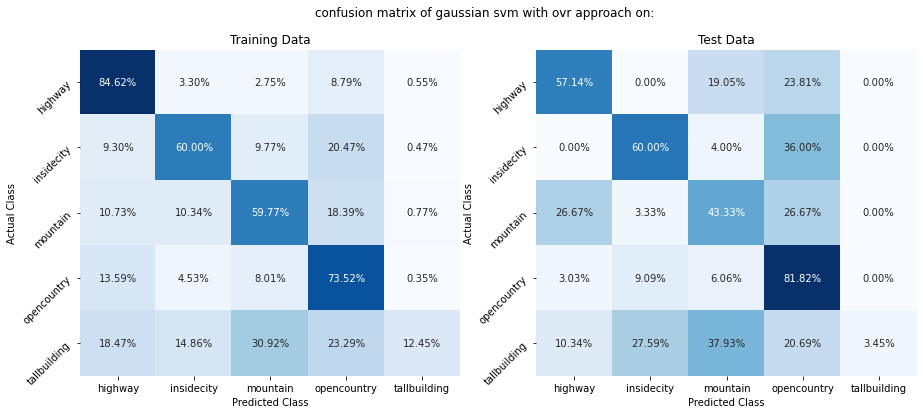

In [40]:
# confusion matrix for best model on training and test data
gamma , c = 1 , 0.001
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
yhat_tr = gaussian_ovr.predict(x_train)

fig = plt.figure(figsize=(15,6))
plt.suptitle(f'confusion matrix of gaussian svm with ovr approach on:')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true') if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False,xticklabels=classes, yticklabels=classes)
    plt.yticks(rotation=45)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()